## Imports

In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
# encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# scaling
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
import os
from typing import List
import string
import time
import re
import ast
import warnings
warnings.filterwarnings('ignore')

In [240]:
DATA_DIR = os.path.join(os.getcwd(), "Dataset", "clean_data")
PATH = os.path.join(DATA_DIR, "clean_train.csv")

In [241]:
train_df = pd.read_csv(PATH)

In [242]:
df = train_df.copy()

In [243]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Ticket,Cabin,Embarked,Name
0,1,0,3,22.0,1,0,7.2500,male,A/5 21171,Missing,S,"Braund, Mr. Owen Harris"
1,2,1,1,38.0,1,0,71.2833,female,PC 17599,C85,C,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,1,3,26.0,0,0,7.9250,female,STON/O2. 3101282,Missing,S,"Heikkinen, Miss. Laina"
3,4,1,1,35.0,1,0,53.1000,female,113803,C123,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,5,0,3,35.0,0,0,8.0500,male,373450,Missing,S,"Allen, Mr. William Henry"


In [244]:
TARGET_COL = ["Survived"]
ID_COL = ["PassengerId"]
TEXT_FEATURES = ["Name"]
CAT_FEATURES = [col for col in df.columns if df[col].dtype == "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]
NUM_FEATURES = [col for col in df.columns if df[col].dtype != "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]

### Functions to use

In [436]:
class DataEncoding:

    def __init__(self, clean_df: pd.DataFrame):
        self.original_df = clean_df.copy()
        self.df = clean_df.copy() # here will perform our encodings

    # label encoding
    def lable_encode(self, input_col:str, output_col:str):
        """
        label encodes the passed column from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        label_encode = LabelEncoder()
        label_encode.fit(self.df[input_col])
        self.df[output_col] = label_encode.transform(self.df[input_col])
        print(f"Applied Label Encoded : {input_col} --> {output_col}")

    # ordinal encoding
    def ordinal_encode(self, input_col:str, output_col:str, categories=List[str]) -> None:
        """
        ordinally encodes the passed column using categories from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.
            cotegories (list): list of all unique values from input col.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        if len(categories) > 0:
            ordinal_encod = OrdinalEncoder(categories=[categories])
        else:
            ordinal_encod = OrdinalEncoder(categories=[self.df[input_col].unique().tolist()])
        self.df[output_col] = ordinal_encod.fit_transform(self.df[[input_col]])
        print(f"Applied Ordinal Encoded : {input_col} --> {output_col}")

    # onehot encoding
    def onehot_encode(self, input_col:str, output_col_initials:str) -> None:
        """
        applies one hot encoding on passed `input_col`
        an renames all onehot encoded columns with 
        initials with `output_col_initials`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col_initials (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col_initials `string` is empty.

        Example:
            >>> 
        """
        if len(output_col_initials) == 0:
            output_col_initials = input_col
        # initalized encoder
        onehot_encode = OneHotEncoder()
        # applying encoding
        onehot_encoded = onehot_encode.fit_transform(self.df[[input_col]]).toarray()

        # Create a DataFrame for the encoded data
        df_encoded = pd.DataFrame(onehot_encoded, columns=onehot_encode.get_feature_names_out([output_col_initials]))

        # Concatenate with original DataFrame
        self.df = pd.concat([self.df, df_encoded], axis=1)
        print(f"OneHotEncoder Applied on : {input_col}")

    def map_custom_encoding(self, input_col:str, output_col:str, encoding:dict) -> None:
        # Apply custom encoding using map
        self.df[output_col] = self.df[input_col].map(encoding)
        print(f"Applied Custom Encoded : {input_col} --> {output_col}")

    def feature_tranformation(self, input_col:str, type_of_trans: str):
        if type_of_trans == "Logarithmic":
            self.df[input_col+"_Log"] = np.log(self.df[input_col])
        elif type_of_trans == "Logarithmic_10": # base 10
            self.df[input_col+"_Log_10"] = np.log10(self.df[input_col])
        elif type_of_trans == "Exponential":
            self.df[input_col+"_Exp"] = np.exp(self.df[input_col])
        elif type_of_trans == "Exponential_2": # power 2
            self.df[input_col+"_Exp_2"] = np.exp2(self.df[input_col])
        elif type_of_trans == "Power":
            transformed_data, _ = boxcox(self.df[input_col])
            self.df[input_col+"_Power"] = transformed_data
        elif type_of_trans == "Square":
            self.df[input_col+"_Squr"] = np.power(self.df[input_col], 2)
        elif type_of_trans == "Cubic":
            self.df[input_col+"_Cube"] = np.power(self.df[input_col], 3)
        else:
            print(f"No transformation applied: {input_col}")
            # self.df[input_col] = self.df[input_col]

    def feature_scaling(self, input_col:str, type_of_scale:str):
        if type_of_scale == "Normal_l1":
            scaler = Normalizer(norm='l1')
            self.df[input_col+"_Norm_l1"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Normal_l2":
            scaler = Normalizer(norm='l2')
            self.df[input_col+"_Norm_l2"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MaxAbcScaler":
            scaler = MaxAbsScaler()
            self.df[input_col+"_MaxAbs"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Rodust":
            scaler = RobustScaler()
            self.df[input_col+"_Robust"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MinMax":
            scaler = MinMaxScaler()
            self.df[input_col+"_MinMax"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Standard":
            scaler = StandardScaler()
            self.df[input_col+"_Standard"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

    def transform_with_all_technique(self, input_col:str):
        techniques = ["Logarithmic", "Logarithmic_10", "Exponential", "Exponential_2", "Power", "Square", "Cubic"]
        for tech in techniques:
            self.feature_tranformation(input_col, tech)
            print(f"Transformed {input_col} with : {tech}")

    def scaling_with_all_technique(self, input_col:str):
        techniques = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Rodust", "MinMax", "Standard"]
        for tech in techniques:
            self.feature_scaling(input_col, tech)
            print(f"Scaled {input_col} with : {tech}")            

### Example to use functions

In [417]:
my_df = pd.DataFrame(
    {
        "label": ['male', 'female', 'male', 'female', 'male', 'female', 'female', 'male', 'male', 'female'],
        "ordinal": ['jan', 'feb', 'march', 'march', 'march', 'feb', 'feb', 'jan', 'feb', 'jan'] ,
        "onehot": ["violate", "indigo", "blue", "green", "orange", "yellow", "red", "white", "black", "brown"],
        "numerical": [np.random.randint(0, 10000) for _ in range(10)]
    }
)

encode_obj = DataEncoding(my_df)

#### Categorical Transformations

In [418]:
encode_obj.lable_encode("label", "label_encode")

Applied Label Encoded : label --> label_encode


In [419]:
encode_obj.ordinal_encode("ordinal", "ordinal_encode", ['march', 'feb', 'jan'])

Applied Ordinal Encoded : ordinal --> ordinal_encode


In [420]:
encode_obj.onehot_encode("onehot", "onehot")

OneHotEncoder Applied on : onehot


In [421]:
encode_obj.df.head()

,label,ordinal,onehot,numerical,label_encode,ordinal_encode,onehot_black,onehot_blue,onehot_brown,onehot_green,onehot_indigo,onehot_orange,onehot_red,onehot_violate,onehot_white,onehot_yellow
0,male,jan,violate,7301,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,female,feb,indigo,9627,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,male,march,blue,9251,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,female,march,green,5756,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,male,march,orange,5200,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Numerical Transformations

In [429]:
encode_trans = DataEncoding(my_df)

In [430]:
encode_trans.original_df.head()

,label,ordinal,onehot,numerical
0,male,jan,violate,7301
1,female,feb,indigo,9627
2,male,march,blue,9251
3,female,march,green,5756
4,male,march,orange,5200


In [431]:
encode_trans.transform_with_all_technique("numerical")

Transformed numerical with : Logarithmic
Transformed numerical with : Logarithmic_10
Transformed numerical with : Exponential
Transformed numerical with : Exponential_2
Transformed numerical with : Power
Transformed numerical with : Square
Transformed numerical with : Cubic


In [432]:
encode_trans.df.head()

,label,ordinal,onehot,numerical,numerical_Log,numerical_Log_10,numerical_Exp,numerical_Exp_2,numerical_Power,numerical_Squr,numerical_Cube
0,male,jan,violate,7301,8.895767,3.863382,inf,inf,13240.275851,53304601,389176891901
1,female,feb,indigo,9627,9.172327,3.983491,inf,inf,17824.961231,92679129,892221974883
2,male,march,blue,9251,9.132487,3.966189,inf,inf,17077.592222,85581001,791709840251
3,female,march,green,5756,8.657998,3.760121,inf,inf,10253.591163,33131536,190705121216
4,male,march,orange,5200,8.556414,3.716003,inf,inf,9192.690754,27040000,140608000000


#### Numerical Scaling and Normalization

In [437]:
encode_scl = DataEncoding(my_df)

In [438]:
encode_scl.original_df.head()

,label,ordinal,onehot,numerical
0,male,jan,violate,7301
1,female,feb,indigo,9627
2,male,march,blue,9251
3,female,march,green,5756
4,male,march,orange,5200


In [439]:
encode_scl.scaling_with_all_technique("numerical")

Scaled numerical with : Normal_l1
Scaled numerical with : Normal_l2
Scaled numerical with : MaxAbcScaler
Scaled numerical with : Rodust
Scaled numerical with : MinMax
Scaled numerical with : Standard


In [440]:
encode_scl.df.head()

,label,ordinal,onehot,numerical,numerical_Norm_l1,numerical_Norm_l2,numerical_MaxAbs,numerical_Robust,numerical_MinMax,numerical_Standard
0,male,jan,violate,7301,1.0,1.0,0.758388,0.766524,0.749542,0.540562
1,female,feb,indigo,9627,1.0,1.0,1.000000,1.903238,1.000000,1.366351
2,male,march,blue,9251,1.0,1.0,0.960943,1.719487,0.959513,1.232861
3,female,march,green,5756,1.0,1.0,0.597902,0.011484,0.583181,-0.007953
4,male,march,orange,5200,1.0,1.0,0.540148,-0.260232,0.523312,-0.205347


# Feature Engineering Starts

## Handeling Text Feature

In [277]:
TEXT_FEATURES

['Name']

In [302]:
# copying text features
TEXT_DF = df[TEXT_FEATURES].copy()

In [337]:
encode_text = DataEncoding(TEXT_DF)

In [304]:
encode_text.df.head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [305]:
TEXT_DF["Name"].apply(lambda x: len(x.split()))

0      4
1      7
2      3
3      7
4      4
      ..
886    3
887    4
888    5
889    4
890    3
Name: Name, Length: 891, dtype: int64

In [306]:
# number of letters in name
encode_text.df["Name_Words"] = TEXT_DF["Name"].apply(lambda x: len(x.split()))
# number of words
encode_text.df["Name_Length"] = TEXT_DF["Name"].apply(lambda x: len(x))
# keeping only 

In [307]:
encode_text.df.head()

,Name,Name_Words,Name_Length
0,"Braund, Mr. Owen Harris",4,23
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",7,51
2,"Heikkinen, Miss. Laina",3,22
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",7,44
4,"Allen, Mr. William Henry",4,24


- Here we are trying to get name initials from those names line `Mr., Mrs, Miss., Dr.` .,etc

In [308]:
TEXT_DF["Name"][0]

'Braund, Mr. Owen Harris'

In [309]:
encode_text.df["Name_Init"] = TEXT_DF["Name"].apply(lambda word: list(filter(lambda word: word.endswith('.'), word.split()))[0][:-1])

In [310]:
encode_text.df.head()

,Name,Name_Words,Name_Length,Name_Init
0,"Braund, Mr. Owen Harris",4,23,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",7,51,Mrs
2,"Heikkinen, Miss. Laina",3,22,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",7,44,Mrs
4,"Allen, Mr. William Henry",4,24,Mr


In [311]:
encode_text.df[["Name_Init"]].describe().T

,count,unique,top,freq
Name_Init,891,17,Mr,517


<Axes: xlabel='count', ylabel='Name_Init'>

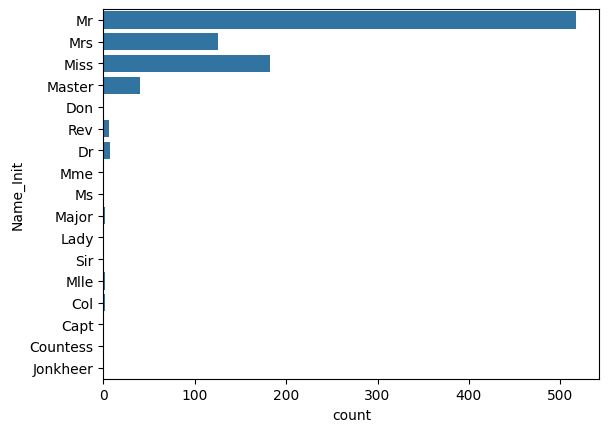

In [312]:
sns.countplot(data=encode_text.df, y="Name_Init")

### Feature Encoding

In [313]:
# name initials
name_init = encode_text.df["Name_Init"].value_counts(ascending=False).keys().tolist()
print(name_init)

['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']


In [338]:
encode_text.lable_encode("Name_Init", "Name_Init_labelencode")
encode_text.ordinal_encode("Name_Init","Name_Init_ordinalencode", name_init)
encode_text.onehot_encode("Name_Init","Name_Init")

Applied Label Encoded : Name_Init --> Name_Init_labelencode
Applied Ordinal Encoded : Name_Init --> Name_Init_ordinalencode
OneHotEncoder Applied on : Name_Init


In [317]:
TEXT_DF = encode_text.df.copy()

In [318]:
TEXT_DF.head()

,Name,Name_Words,Name_Length,Name_Init,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,...,Name_Init_Major,Name_Init_Master,Name_Init_Miss,Name_Init_Mlle,Name_Init_Mme,Name_Init_Mr,Name_Init_Mrs,Name_Init_Ms,Name_Init_Rev,Name_Init_Sir
0,"Braund, Mr. Owen Harris",4,23,Mr,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",7,51,Mrs,13,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"Heikkinen, Miss. Laina",3,22,Miss,9,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",7,44,Mrs,13,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"Allen, Mr. William Henry",4,24,Mr,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [319]:
TEXT_COLS_ENCODED = [col for col in TEXT_DF.columns if col not in ["Name", "Name_Init"]]

In [320]:
TEXT_COLS_ENCODED

['Name_Words',
 'Name_Length',
 'Name_Init_labelencode',
 'Name_Init_ordinalencode',
 'Name_Init_Capt',
 'Name_Init_Col',
 'Name_Init_Countess',
 'Name_Init_Don',
 'Name_Init_Dr',
 'Name_Init_Jonkheer',
 'Name_Init_Lady',
 'Name_Init_Major',
 'Name_Init_Master',
 'Name_Init_Miss',
 'Name_Init_Mlle',
 'Name_Init_Mme',
 'Name_Init_Mr',
 'Name_Init_Mrs',
 'Name_Init_Ms',
 'Name_Init_Rev',
 'Name_Init_Sir']

In [321]:
ENCODED_TEXT_DATA = TEXT_DF[TEXT_COLS_ENCODED].copy()

In [322]:
ENCODED_TEXT_DATA.head()

,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,Name_Init_Dr,Name_Init_Jonkheer,...,Name_Init_Major,Name_Init_Master,Name_Init_Miss,Name_Init_Mlle,Name_Init_Mme,Name_Init_Mr,Name_Init_Mrs,Name_Init_Ms,Name_Init_Rev,Name_Init_Sir
0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Handeling Categorical Feature

In [323]:
CAT_FEATURES

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [324]:
# copying categorical features
CAT_DF = df[CAT_FEATURES].copy()

In [325]:
CAT_DF.head()

,Sex,Ticket,Cabin,Embarked
0,male,A/5 21171,Missing,S
1,female,PC 17599,C85,C
2,female,STON/O2. 3101282,Missing,S
3,female,113803,C123,S
4,male,373450,Missing,S


### Feature Engineering : Sex

In [339]:
encode_cat = DataEncoding(CAT_DF)

#### Feature Encoding : Sex

In [340]:
encode_cat.lable_encode("Sex", "Sex_labelencode")

Applied Label Encoded : Sex --> Sex_labelencode


In [341]:
encode_cat.df.head()

,Sex,Ticket,Cabin,Embarked,Sex_labelencode
0,male,A/5 21171,Missing,S,1
1,female,PC 17599,C85,C,0
2,female,STON/O2. 3101282,Missing,S,0
3,female,113803,C123,S,0
4,male,373450,Missing,S,1


### Feature Engineering : Embarked

<Axes: xlabel='count', ylabel='Embarked'>

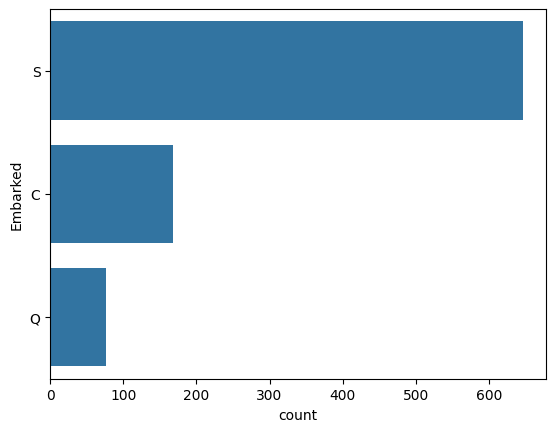

In [342]:
sns.countplot(data=CAT_DF, y="Embarked")

- Embarked - basically stations or can say stops from where passengers onboarded the ship

`S = Southampton [0], C = Cherbourg [1], Q = Queenstown [2], `

#### Feature Encoding : Embarked

In [343]:
encode_cat.lable_encode("Embarked", "Embraked_labelencoded")

Applied Label Encoded : Embarked --> Embraked_labelencoded


In [344]:
encode_cat.ordinal_encode("Embarked", "Embarked_ordinalencode", ['S', 'C', 'Q'])

Applied Ordinal Encoded : Embarked --> Embarked_ordinalencode


In [345]:
encode_cat.onehot_encode("Embarked", "Embarked")

OneHotEncoder Applied on : Embarked


In [346]:
encode_cat.df.head()

,Sex,Ticket,Cabin,Embarked,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S
0,male,A/5 21171,Missing,S,1,2,0.0,0.0,0.0,1.0
1,female,PC 17599,C85,C,0,0,1.0,1.0,0.0,0.0
2,female,STON/O2. 3101282,Missing,S,0,2,0.0,0.0,0.0,1.0
3,female,113803,C123,S,0,2,0.0,0.0,0.0,1.0
4,male,373450,Missing,S,1,2,0.0,0.0,0.0,1.0


## Handeling Numerical Feature

In [347]:
NUM_FEATURES

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [348]:
# copying numerical features
NUM_DF = df[NUM_FEATURES].copy()

In [349]:
NUM_DF.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


#### Feature Engineering : Transformation

## Scaling and Normalization

Scaling entire data 

## Data Export

In [356]:
def export_data(list_of_data:List, file_name:str) -> None:
    final_data = pd.concat(list_of_data, axis=1)
    PATH  = os.path.join(DATA_DIR, "Transformed_data")
    os.makedirs(PATH, exist_ok=True)
    SAVE_PATH  = os.path.join(PATH, file_name)
    final_data.to_csv(SAVE_PATH, index=False)
    print(f"Saved at: {SAVE_PATH}")

In [357]:
export_data(list_of_data=[encode_text.df, encode_cat.df], 
            file_name="train_iteratoin4.csv")

Saved at: f:\Data Science\Rahul Data Science\INeuron\Projects\Titanic_Problem_Kaggel\Dataset\clean_data\Transformed_data\train_iteratoin4.csv
